RDF-related info for CN-dtrajs of 80:20 KA sims
====

In [1]:
import pyemma
pyemma.__version__

'2.1.1'

In [2]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt

Some useful inhouse functions
------

In [4]:
from CN_functions import *
from gen_dtraj_functions import *

Now, load coordinates
------

In [5]:
indir = '/data/isilon/rudzinski/cluster_tmp/LJ/Kobb_Andersen/DiffCoeff_red-dt_30ns/T0.4'
topfile =  indir+'/LJ_1frame.pdb'
traj_list = []
Nf = 1
traj_fnm = indir+'/traj/config_series_sim_T0.4_10-15ns.xtc'
traj_list.append(traj_fnm)

In [6]:
feat = coor.featurizer(topfile)

/people/thnfs/homes/rudzinski/soft/PyEMMA-2-cluster/.eggs/mdtraj-1.7.2-py2.7-linux-x86_64.egg/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors...JFR - that was the original warning, but this does not apply to me! Leaving the unit cell vectors in!!
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [7]:
# select all the indices with a particular site name, nb - site indices are 0-indexed
#print feat.topology.select("name B")
# select a particular molecule, nb - residue numbers are 1-indexed
print feat.topology.select("residue 1")
# total number of sites
print feat.topology.n_atoms
# total number of molecules
print feat.topology.n_residues

[0]
5000
5000


In [8]:
#traj_dt = 1 # in ps
#n_frames_p_traj = 1001
n_mol = feat.topology.n_residues
n_sites_p_mol = feat.topology.n_atoms / n_mol

Start with considering only solvation of A and B types

In [9]:
n_excl = n_sites_p_mol
sel_1 = 'name A'
sel_2 = 'name B'
n_excl

1

In [10]:
AA_pairs_excl = get_excl_pair_list( feat.topology, sel_1, sel_1, n_excl, n_sites_p_mol )
AB_pairs_excl = get_excl_pair_list( feat.topology, sel_1, sel_2, n_excl, n_sites_p_mol )
BB_pairs_excl = get_excl_pair_list( feat.topology, sel_2, sel_2, n_excl, n_sites_p_mol )

In [11]:
# calc the rdf, now by chunk
(r_AA, gr_AA), count = calc_chunkwise( lambda x: md.compute_rdf(x, pairs=AA_pairs_excl, r_range=(0,0.6), bin_width=0.001, n_bins=None, periodic=True, opt=True), traj_list, topfile, chunk_size=50, dim=2, stride=10 )

/people/thnfs/homes/rudzinski/soft/PyEMMA-2-cluster/.eggs/mdtraj-1.7.2-py2.7-linux-x86_64.egg/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors...JFR - that was the original warning, but this does not apply to me! Leaving the unit cell vectors in!!
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


[ 0.1415  0.1945  0.2365  0.3305  0.4105  0.4125  0.4155  0.4625  0.5015
  0.5075]
[ 0.1045  0.1875  0.2065  0.2765  0.3695  0.4115  0.4145  0.4615  0.4635
  0.5055]


(0.05, 0.7)

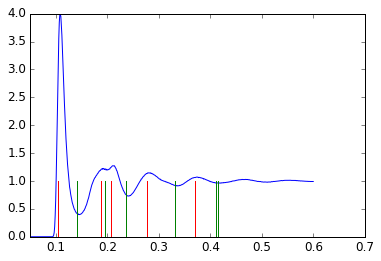

In [12]:
# use gp(r) to find the first few local min and max and check against the rdf
gr_min_AA = get_loc_extr( r_AA, gr_AA, 10, 10, False)
print gr_min_AA
gr_max_AA = get_loc_extr( r_AA, gr_AA, 10, 10, True)
print gr_max_AA
# plot g(r)
plt.plot(r_AA,gr_AA)
# plot the extr to determine placement of weight functions
# 1st solvation shell
plt.plot(gr_max_AA[0]*np.ones(3),[0,0.5,1],c='r')
plt.plot(gr_min_AA[0]*np.ones(3),[0,0.5,1],c='g')
# 2nd solvation shell
plt.plot(gr_max_AA[1]*np.ones(3),[0,0.5,1],c='r')
plt.plot(gr_min_AA[1]*np.ones(3),[0,0.5,1],c='g')
# 3rd solvation shell
plt.plot(gr_max_AA[2]*np.ones(3),[0,0.5,1],c='r')
plt.plot(gr_min_AA[2]*np.ones(3),[0,0.5,1],c='g')
#
plt.plot(gr_max_AA[3]*np.ones(3),[0,0.5,1],c='r')
plt.plot(gr_min_AA[3]*np.ones(3),[0,0.5,1],c='g')
#
plt.plot(gr_max_AA[4]*np.ones(3),[0,0.5,1],c='r')
plt.plot(gr_min_AA[4]*np.ones(3),[0,0.5,1],c='g')
#
plt.plot(gr_max_AA[6]*np.ones(3),[0,0.5,1],c='r')
plt.plot(gr_min_AA[6]*np.ones(3),[0,0.5,1],c='g')
#
plt.xlim([0.05,0.7])

(0.05, 0.55)

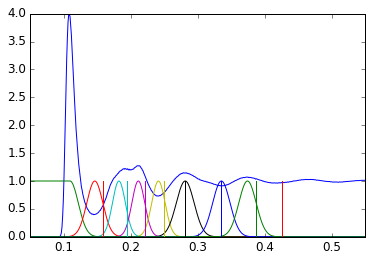

In [15]:
# now define weighting functions for the CNs based on these shells
solshel_max_AA_1 = gr_max_AA[0]+0.005
solshel_max_AA_2 = gr_min_AA[0]+0.005
solshel_max_AA_3 = gr_max_AA[1]-0.005
solshel_max_AA_4 = gr_max_AA[2]+0.005
solshel_max_AA_5 = gr_min_AA[2]+0.005
solshel_max_AA_6 = gr_max_AA[3]+0.005
solshel_max_AA_7 = gr_min_AA[3]+0.005
solshel_max_AA_8 = gr_max_AA[4]+0.005
#
sig_AA_1 = (solshel_max_AA_2 - solshel_max_AA_1)/3.
weight_AA_1 = [ np.exp(-(1./(2.*sig_AA_1**2))*(x - solshel_max_AA_1)**2) if x > solshel_max_AA_1 else 1 for x in r_AA ]
#
sig_AA_2 = min( sig_AA_1, (solshel_max_AA_3 - solshel_max_AA_2)/3. )
weight_AA_2 = [ np.exp(-(1./(2.*sig_AA_2**2))*(x - solshel_max_AA_2)**2) for x in r_AA ]
#
sig_AA_3 = min( (solshel_max_AA_3 - solshel_max_AA_2)/3., (solshel_max_AA_4 - solshel_max_AA_3)/3. )
weight_AA_3 = [ np.exp(-(1./(2.*sig_AA_3**2))*(x - solshel_max_AA_3)**2) for x in r_AA ]
#
sig_AA_4 = min( (solshel_max_AA_4 - solshel_max_AA_3)/3., (solshel_max_AA_5 - solshel_max_AA_4)/3. )
weight_AA_4 = [ np.exp(-(1./(2.*sig_AA_4**2))*(x - solshel_max_AA_4)**2) for x in r_AA ]
#
sig_AA_5 = min( (solshel_max_AA_5 - solshel_max_AA_4)/3., (solshel_max_AA_6 - solshel_max_AA_5)/3. )
weight_AA_5 = [ np.exp(-(1./(2.*sig_AA_5**2))*(x - solshel_max_AA_5)**2) for x in r_AA ]
#
sig_AA_6 = min( (solshel_max_AA_6 - solshel_max_AA_5)/3., (solshel_max_AA_7 - solshel_max_AA_6)/3. )
weight_AA_6 = [ np.exp(-(1./(2.*sig_AA_6**2))*(x - solshel_max_AA_6)**2) for x in r_AA ]
#
sig_AA_7 = min( (solshel_max_AA_7 - solshel_max_AA_6)/3., (solshel_max_AA_8 - solshel_max_AA_7)/3. )
weight_AA_7 = [ np.exp(-(1./(2.*sig_AA_7**2))*(x - solshel_max_AA_7)**2) for x in r_AA ]
#
sig_AA_8 = (solshel_max_AA_8 - solshel_max_AA_7)/3.
weight_AA_8 = [ np.exp(-(1./(2.*sig_AA_8**2))*(x - solshel_max_AA_8)**2) for x in r_AA ]
#
plt.plot(r_AA,gr_AA)
plt.plot( r_AA, weight_AA_1 )
plt.plot( r_AA, weight_AA_2 )
plt.plot( r_AA, weight_AA_3 )
plt.plot( r_AA, weight_AA_4 )
plt.plot( r_AA, weight_AA_5 )
plt.plot( r_AA, weight_AA_6 )
plt.plot( r_AA, weight_AA_7 )
plt.plot( r_AA, weight_AA_8 )
#
rcut_AA_1 = solshel_max_AA_1 + 4.*sig_AA_1
plt.plot( rcut_AA_1*np.ones(3),[0,0.5,1] )
rcut_AA_2 = solshel_max_AA_2 + 4.*sig_AA_2
plt.plot( rcut_AA_2*np.ones(3),[0,0.5,1] )
rcut_AA_3 = solshel_max_AA_3 + 4.*sig_AA_3
plt.plot( rcut_AA_3*np.ones(3),[0,0.5,1] )
rcut_AA_4 = solshel_max_AA_4 + 4.*sig_AA_4
plt.plot( rcut_AA_4*np.ones(3),[0,0.5,1] )
rcut_AA_5 = solshel_max_AA_5 + 4.*sig_AA_5
plt.plot( rcut_AA_5*np.ones(3),[0,0.5,1] )
rcut_AA_6 = solshel_max_AA_6 + 4.*sig_AA_6
plt.plot( rcut_AA_6*np.ones(3),[0,0.5,1] )
rcut_AA_7 = solshel_max_AA_7 + 4.*sig_AA_7
plt.plot( rcut_AA_7*np.ones(3),[0,0.5,1] )
rcut_AA_8 = solshel_max_AA_8 + 4.*sig_AA_8
plt.plot( rcut_AA_8*np.ones(3),[0,0.5,1] )
#
plt.xlim([0.05,0.55])

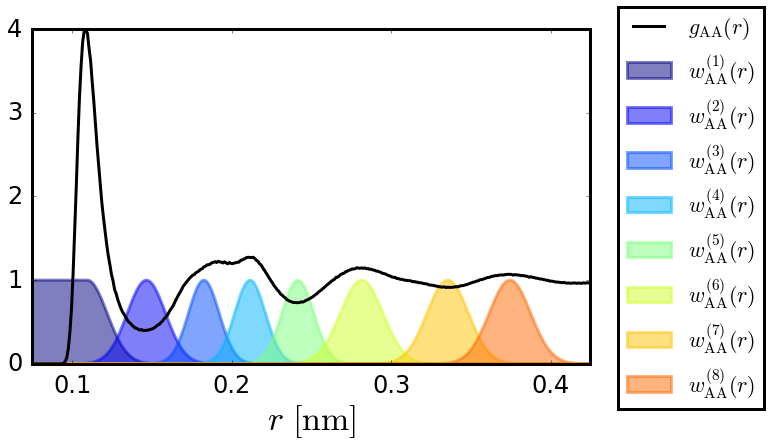

In [17]:
# replot for a figure describing the features
# first define the colors for the features
# alternative for defining model colors
from matplotlib import pyplot as plt
from matplotlib.pyplot import *

N_feat = 10
mycmap = plt.cm.jet
mycmap_max = N_feat
mycmap_min = 0
# extract all colors from the .jet map
mycmaplist = [mycmap(i) for i in range(mycmap.N)]
# create the new map
mycmap = mycmap.from_list('Custom cmap', mycmaplist, mycmap.N)
# define the bins and normalize
bounds = np.linspace(mycmap_min,mycmap_max,mycmap.N)
norm = matplotlib.colors.BoundaryNorm(bounds, mycmap.N)
mycmaplist = [mycmap(i) for i in range(mycmap.N)]
dx = bounds[1] - bounds[0]
model_colors = []
for model in range(N_feat):
    if ( model < 4 ): # skip yellow
        grid = int( (model - mycmap_min)/dx + 0.5 )
    else:
        grid = int( (model+1 - mycmap_min)/dx + 0.5 )
    model_colors.append(mycmaplist[grid])

#
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
#
plt.plot(r_AA,gr_AA,color='k',linewidth=3.0,label=r'$g_{\rm{AA}}(r)$')
plt.fill_between( r_AA, weight_AA_1, alpha=0.5, color=model_colors[0], linewidth=3.0, label=r'$w_{\rm{AA}}^{(1)}(r)$' )
plt.fill_between( r_AA, weight_AA_2, alpha=0.5, color=model_colors[1], linewidth=3.0, label=r'$w_{\rm{AA}}^{(2)}(r)$' )
plt.fill_between( r_AA, weight_AA_3, alpha=0.5, color=model_colors[2], linewidth=3.0, label=r'$w_{\rm{AA}}^{(3)}(r)$' )
plt.fill_between( r_AA, weight_AA_4, alpha=0.5, color=model_colors[3], linewidth=3.0, label=r'$w_{\rm{AA}}^{(4)}(r)$' )
plt.fill_between( r_AA, weight_AA_5, alpha=0.5, color=model_colors[4], linewidth=3.0, label=r'$w_{\rm{AA}}^{(5)}(r)$' )
plt.fill_between( r_AA, weight_AA_6, alpha=0.5, color=model_colors[5], linewidth=3.0, label=r'$w_{\rm{AA}}^{(6)}(r)$' )
plt.fill_between( r_AA, weight_AA_7, alpha=0.5, color=model_colors[6], linewidth=3.0, label=r'$w_{\rm{AA}}^{(7)}(r)$' )
plt.fill_between( r_AA, weight_AA_8, alpha=0.5, color=model_colors[7], linewidth=3.0, label=r'$w_{\rm{AA}}^{(8)}(r)$' )
#

ax.spines['left'].set_linewidth(3.0)
ax.spines['right'].set_linewidth(3.0)
ax.spines['top'].set_linewidth(3.0)
ax.spines['bottom'].set_linewidth(3.0)
plt.xlabel(r'$r \,\, [\rm{nm}]$',fontsize='34',fontweight='bold')
#plt.ylabel('abs err',fontsize='28',labelpad=10)
plt.yticks([0,1,2,3,4],fontsize='24')
#eqm_prop_label = [r'$\langle N_c \rangle $',r'$\langle N_h \rangle$',r'$\langle N_s \rangle$',r'$\langle N_l \rangle$']
plt.xticks([0.1,0.2,0.3,0.4,0.5],fontsize='24')
ax.tick_params(axis='both', which='major', pad=10)
# legend
plt.legend()
legend = plt.legend(fontsize='22',loc='upper center', bbox_to_anchor=(1.18, 1.1))
frame = legend.get_frame()
frame.set_linewidth('3.0')
ltext = legend.get_texts()
plt.setp(ltext, fontweight='normal')
#
plt.ylim([0,4])
plt.xlim([0.075,0.425])
plt.savefig('fig_gAA_feat-weights.svg', format='svg', dpi=1200)
plt.savefig('fig_gAA_feat-weights.eps', format='eps', dpi=1200)
plt.show()

In [18]:
# save all the data for this rdf
np.savez('data_AA_rdf', sel=sel_1, pairs_excl=AA_pairs_excl, r=r_AA, gr=gr_AA, N_solshel=8, solshel_max=[solshel_max_AA_1,solshel_max_AA_2,solshel_max_AA_3,solshel_max_AA_4,solshel_max_AA_5,solshel_max_AA_6,solshel_max_AA_7,solshel_max_AA_8], sig=[sig_AA_1,sig_AA_2,sig_AA_3,sig_AA_4,sig_AA_5,sig_AA_6,sig_AA_7,sig_AA_8], rcut=[rcut_AA_1,rcut_AA_2,rcut_AA_3,rcut_AA_4,rcut_AA_5,rcut_AA_6,rcut_AA_7,rcut_AA_8], weight=[weight_AA_1,weight_AA_2,weight_AA_3,weight_AA_4,weight_AA_5,weight_AA_6,weight_AA_7,weight_AA_8])






In [19]:
# calc the rdf, now by chunk
(r_AB, gr_AB), count = calc_chunkwise( lambda x: md.compute_rdf(x, pairs=AB_pairs_excl, r_range=(0,0.6), bin_width=0.001, n_bins=None, periodic=True, opt=True), traj_list, topfile, chunk_size=50, dim=2, stride=10 )

/people/thnfs/homes/rudzinski/soft/PyEMMA-2-cluster/.eggs/mdtraj-1.7.2-py2.7-linux-x86_64.egg/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors...JFR - that was the original warning, but this does not apply to me! Leaving the unit cell vectors in!!
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


[ 0.1225  0.1725  0.2185  0.3125  0.3975  0.4425  0.4825  0.4855  0.4875
  0.4905]
[ 0.0855  0.1665  0.1865  0.2595  0.3515  0.4405  0.4435  0.4835  0.4865
  0.4895]


(4000000, 2)

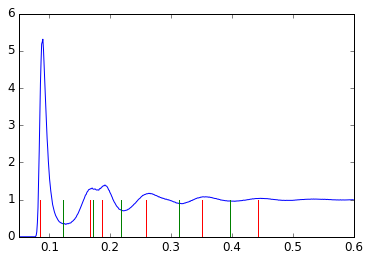

In [20]:
# use gp(r) to find the first few local min and max and check against the rdf
gr_min_AB = get_loc_extr( r_AB, gr_AB, 10, 10, False)
print gr_min_AB
gr_max_AB = get_loc_extr( r_AB, gr_AB, 10, 10, True)
print gr_max_AB
# plot g(r)
plt.plot(r_AB,gr_AB)
# plot the extr to determine placement of weight functions
# 1st solvation shell
plt.plot(gr_max_AB[0]*np.ones(3),[0,0.5,1],c='r')
plt.plot(gr_min_AB[0]*np.ones(3),[0,0.5,1],c='g')
# 2nd solvation shell
plt.plot(gr_max_AB[1]*np.ones(3),[0,0.5,1],c='r')
plt.plot(gr_min_AB[1]*np.ones(3),[0,0.5,1],c='g')
# 3rd solvation shell
plt.plot(gr_max_AB[2]*np.ones(3),[0,0.5,1],c='r')
plt.plot(gr_min_AB[2]*np.ones(3),[0,0.5,1],c='g')
#
plt.plot(gr_max_AB[3]*np.ones(3),[0,0.5,1],c='r')
plt.plot(gr_min_AB[3]*np.ones(3),[0,0.5,1],c='g')
#
plt.plot(gr_max_AB[4]*np.ones(3),[0,0.5,1],c='r')
plt.plot(gr_min_AB[4]*np.ones(3),[0,0.5,1],c='g')
#
plt.plot(gr_max_AB[6]*np.ones(3),[0,0.5,1],c='r')
#plt.plot(gr_min_AB[5]*np.ones(3),[0,0.5,1],c='g')
#
plt.xlim([0.05,0.6])
AB_pairs_excl.shape

(0.05, 0.5)

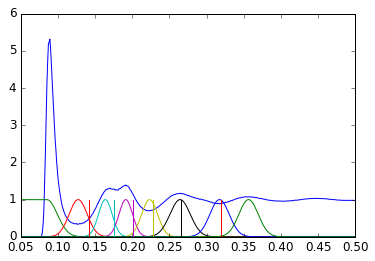

In [23]:
# now define weighting functions for the CNs based on these shells
solshel_max_AB_1 = gr_max_AB[0]
solshel_max_AB_2 = gr_min_AB[0]+0.005
solshel_max_AB_3 = gr_max_AB[1]-0.0025
solshel_max_AB_4 = gr_max_AB[2]+0.005
solshel_max_AB_5 = gr_min_AB[2]+0.005
solshel_max_AB_6 = gr_max_AB[3]+0.005
solshel_max_AB_7 = gr_min_AB[3]+0.005
solshel_max_AB_8 = gr_max_AB[4]+0.005
#
sig_AB_1 = (solshel_max_AB_2 - solshel_max_AB_1)/3.
weight_AB_1 = [ np.exp(-(1./(2.*sig_AB_1**2))*(x - solshel_max_AB_1)**2) if x > solshel_max_AB_1 else 1 for x in r_AB ]
#
sig_AB_2 = min( sig_AB_1, (solshel_max_AB_3 - solshel_max_AB_2)/3. )
weight_AB_2 = [ np.exp(-(1./(2.*sig_AB_2**2))*(x - solshel_max_AB_2)**2) for x in r_AB ]
#
sig_AB_3 = min( (solshel_max_AB_3 - solshel_max_AB_2)/3., (solshel_max_AB_4 - solshel_max_AB_3)/3. )
weight_AB_3 = [ np.exp(-(1./(2.*sig_AB_3**2))*(x - solshel_max_AB_3)**2) for x in r_AB ]
#
sig_AB_4 = min( (solshel_max_AB_4 - solshel_max_AB_3)/3., (solshel_max_AB_5 - solshel_max_AB_4)/3. )
weight_AB_4 = [ np.exp(-(1./(2.*sig_AB_4**2))*(x - solshel_max_AB_4)**2) for x in r_AB ]
#
sig_AB_5 = min( (solshel_max_AB_5 - solshel_max_AB_4)/3., (solshel_max_AB_6 - solshel_max_AB_5)/3. )
weight_AB_5 = [ np.exp(-(1./(2.*sig_AB_5**2))*(x - solshel_max_AB_5)**2) for x in r_AB ]
#
sig_AB_6 = min( (solshel_max_AB_6 - solshel_max_AB_5)/3., (solshel_max_AB_7 - solshel_max_AB_6)/3. )
weight_AB_6 = [ np.exp(-(1./(2.*sig_AB_6**2))*(x - solshel_max_AB_6)**2) for x in r_AB ]
#
sig_AB_7 = min( (solshel_max_AB_7 - solshel_max_AB_6)/3., (solshel_max_AB_8 - solshel_max_AB_7)/3. )
weight_AB_7 = [ np.exp(-(1./(2.*sig_AB_7**2))*(x - solshel_max_AB_7)**2) for x in r_AB ]
#
sig_AB_8 = (solshel_max_AB_8 - solshel_max_AB_7)/3.
weight_AB_8 = [ np.exp(-(1./(2.*sig_AB_8**2))*(x - solshel_max_AB_8)**2) for x in r_AB ]
#
plt.plot(r_AB,gr_AB)
plt.plot( r_AB, weight_AB_1 )
plt.plot( r_AB, weight_AB_2 )
plt.plot( r_AB, weight_AB_3 )
plt.plot( r_AB, weight_AB_4 )
plt.plot( r_AB, weight_AB_5 )
plt.plot( r_AB, weight_AB_6 )
plt.plot( r_AB, weight_AB_7 )
plt.plot( r_AB, weight_AB_8 )
#
rcut_AB_1 = solshel_max_AB_1 + 4.*sig_AB_1
plt.plot( rcut_AB_1*np.ones(3),[0,0.5,1] )
rcut_AB_2 = solshel_max_AB_2 + 4.*sig_AB_2
plt.plot( rcut_AB_2*np.ones(3),[0,0.5,1] )
rcut_AB_3 = solshel_max_AB_3 + 4.*sig_AB_3
plt.plot( rcut_AB_3*np.ones(3),[0,0.5,1] )
rcut_AB_4 = solshel_max_AB_4 + 4.*sig_AB_4
plt.plot( rcut_AB_4*np.ones(3),[0,0.5,1] )
rcut_AB_5 = solshel_max_AB_5 + 4.*sig_AB_5
plt.plot( rcut_AB_5*np.ones(3),[0,0.5,1] )
rcut_AB_6 = solshel_max_AB_6 + 4.*sig_AB_6
plt.plot( rcut_AB_6*np.ones(3),[0,0.5,1] )
rcut_AB_7 = solshel_max_AB_7 + 4.*sig_AB_7
plt.plot( rcut_AB_6*np.ones(3),[0,0.5,1] )
rcut_AB_8 = solshel_max_AB_8 + 4.*sig_AB_8
plt.plot( rcut_AB_6*np.ones(3),[0,0.5,1] )
#
plt.xlim([0.05,0.5])

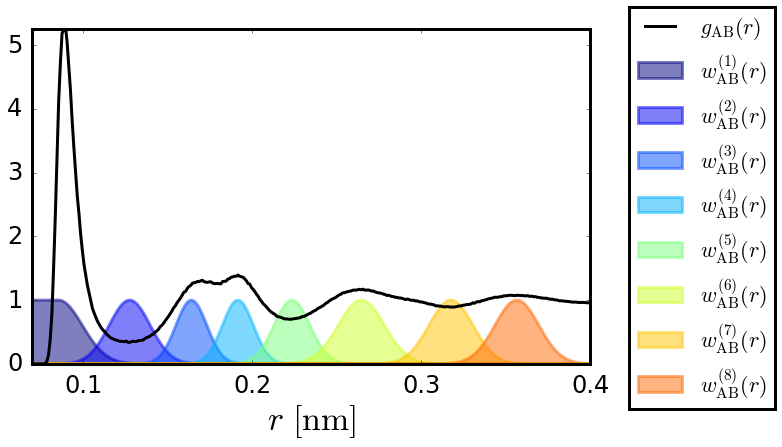

In [25]:
# replot for a figure describing the features
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
#
plt.plot(r_AB,gr_AB,color='k',linewidth=3.0,label=r'$g_{\rm{AB}}(r)$')
plt.fill_between( r_AB, weight_AB_1, alpha=0.5, color=model_colors[0], linewidth=3.0, label=r'$w_{\rm{AB}}^{(1)}(r)$' )
plt.fill_between( r_AB, weight_AB_2, alpha=0.5, color=model_colors[1], linewidth=3.0, label=r'$w_{\rm{AB}}^{(2)}(r)$' )
plt.fill_between( r_AB, weight_AB_3, alpha=0.5, color=model_colors[2], linewidth=3.0, label=r'$w_{\rm{AB}}^{(3)}(r)$' )
plt.fill_between( r_AB, weight_AB_4, alpha=0.5, color=model_colors[3], linewidth=3.0, label=r'$w_{\rm{AB}}^{(4)}(r)$' )
plt.fill_between( r_AB, weight_AB_5, alpha=0.5, color=model_colors[4], linewidth=3.0, label=r'$w_{\rm{AB}}^{(5)}(r)$' )
plt.fill_between( r_AB, weight_AB_6, alpha=0.5, color=model_colors[5], linewidth=3.0, label=r'$w_{\rm{AB}}^{(6)}(r)$' )
plt.fill_between( r_AB, weight_AB_7, alpha=0.5, color=model_colors[6], linewidth=3.0, label=r'$w_{\rm{AB}}^{(7)}(r)$' )
plt.fill_between( r_AB, weight_AB_8, alpha=0.5, color=model_colors[7], linewidth=3.0, label=r'$w_{\rm{AB}}^{(8)}(r)$' )
#

ax.spines['left'].set_linewidth(3.0)
ax.spines['right'].set_linewidth(3.0)
ax.spines['top'].set_linewidth(3.0)
ax.spines['bottom'].set_linewidth(3.0)
plt.xlabel(r'$r \,\, [\rm{nm}]$',fontsize='34',fontweight='bold')
#plt.ylabel('abs err',fontsize='28',labelpad=10)
plt.yticks([0,1,2,3,4,5],fontsize='24')
#eqm_prop_label = [r'$\langle N_c \rangle $',r'$\langle N_h \rangle$',r'$\langle N_s \rangle$',r'$\langle N_l \rangle$']
plt.xticks([0.1,0.2,0.3,0.4,0.5],fontsize='24')
ax.tick_params(axis='both', which='major', pad=10)
# legend
plt.legend()
legend = plt.legend(fontsize='22',loc='upper center', bbox_to_anchor=(1.2, 1.1))
frame = legend.get_frame()
frame.set_linewidth('3.0')
ltext = legend.get_texts()
plt.setp(ltext, fontweight='normal')
#
plt.ylim([0,5.25])
plt.xlim([0.07,0.4])
plt.savefig('fig_gAB_feat-weights.svg', format='svg', dpi=1200)
plt.savefig('fig_gAB_feat-weights.eps', format='eps', dpi=1200)
plt.show()

In [26]:
# save all the data for this rdf
np.savez('data_AB_rdf', sel='all', pairs_excl=AB_pairs_excl, r=r_AB, gr=gr_AB, N_solshel=8, solshel_max=[solshel_max_AB_1,solshel_max_AB_2,solshel_max_AB_3,solshel_max_AB_4,solshel_max_AB_5,solshel_max_AB_6,solshel_max_AB_7,solshel_max_AB_8], sig=[sig_AB_1,sig_AB_2,sig_AB_3,sig_AB_4,sig_AB_5,sig_AB_6,sig_AB_7,sig_AB_8], rcut=[rcut_AB_1,rcut_AB_2,rcut_AB_3,rcut_AB_4,rcut_AB_5,rcut_AB_6,rcut_AB_7,rcut_AB_8], weight=[weight_AB_1,weight_AB_2,weight_AB_3,weight_AB_4,weight_AB_5,weight_AB_6,weight_AB_7,weight_AB_8])






In [27]:
# calc the rdf, now by chunk
(r_BB, gr_BB), count = calc_chunkwise( lambda x: md.compute_rdf(x, pairs=BB_pairs_excl, r_range=(0,0.6), bin_width=0.001, n_bins=None, periodic=True, opt=True), traj_list, topfile, chunk_size=50, dim=2 )

/people/thnfs/homes/rudzinski/soft/PyEMMA-2-cluster/.eggs/mdtraj-1.7.2-py2.7-linux-x86_64.egg/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors...JFR - that was the original warning, but this does not apply to me! Leaving the unit cell vectors in!!
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


[ 0.1015  0.1545  0.1975  0.2925  0.3795  0.3815  0.4685  0.5155  0.5575]
[ 0.0975  0.1355  0.1685  0.2395  0.3345  0.3805  0.4245  0.5135  0.5165
  0.5905]


(499500, 2)

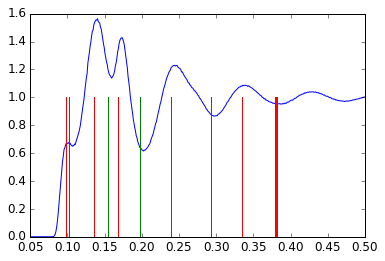

In [28]:
# use gp(r) to find the first few local min and max and check against the rdf
gr_min_BB = get_loc_extr( r_BB, gr_BB, 10, 10, False)
print gr_min_BB
gr_max_BB = get_loc_extr( r_BB, gr_BB, 10, 10, True)
print gr_max_BB
# plot g(r)
plt.plot(r_BB,gr_BB)
# plot the extr to determine placement of weight functions
# 1st solvation shell
plt.plot(gr_max_BB[0]*np.ones(3),[0,0.5,1],c='r')
plt.plot(gr_min_BB[0]*np.ones(3),[0,0.5,1],c='g')
# 2nd solvation shell
plt.plot(gr_max_BB[1]*np.ones(3),[0,0.5,1],c='r')
plt.plot(gr_min_BB[1]*np.ones(3),[0,0.5,1],c='g')
# 3rd solvation shell
plt.plot(gr_max_BB[2]*np.ones(3),[0,0.5,1],c='r')
plt.plot(gr_min_BB[2]*np.ones(3),[0,0.5,1],c='g')
#
plt.plot(gr_max_BB[3]*np.ones(3),[0,0.5,1],c='r')
plt.plot(gr_min_BB[3]*np.ones(3),[0,0.5,1],c='g')
#
plt.plot(gr_max_BB[4]*np.ones(3),[0,0.5,1],c='r')
plt.plot(gr_min_BB[4]*np.ones(3),[0,0.5,1],c='g')
#
plt.plot(gr_max_BB[5]*np.ones(3),[0,0.5,1],c='r')
plt.plot(gr_min_BB[5]*np.ones(3),[0,0.5,1],c='g')
#
plt.xlim([0.05,0.5])
BB_pairs_excl.shape

(0.05, 0.5)

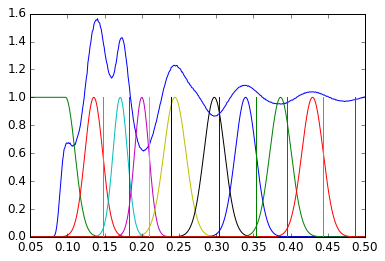

In [31]:
# now define weighting functions for the CNs based on these shells
solshel_max_BB_1 = gr_max_BB[0]
solshel_max_BB_2 = gr_max_BB[1]
solshel_max_BB_3 = gr_max_BB[2]+0.0025
solshel_max_BB_4 = gr_min_BB[2]+0.0025
solshel_max_BB_5 = gr_max_BB[3]+0.005
solshel_max_BB_6 = gr_min_BB[3]+0.005
solshel_max_BB_7 = gr_max_BB[4]+0.005
solshel_max_BB_8 = gr_min_BB[5]+0.005
solshel_max_BB_9 = gr_max_BB[6]+0.005
#
sig_BB_1 = (solshel_max_BB_2 - solshel_max_BB_1)/3.
weight_BB_1 = [ np.exp(-(1./(2.*sig_BB_1**2))*(x - solshel_max_BB_1)**2) if x > solshel_max_BB_1 else 1 for x in r_BB ]
#
sig_BB_2 = min( sig_BB_1, (solshel_max_BB_3 - solshel_max_BB_2)/3. )
weight_BB_2 = [ np.exp(-(1./(2.*sig_BB_2**2))*(x - solshel_max_BB_2)**2) for x in r_BB ]
#
sig_BB_3 = min( (solshel_max_BB_3 - solshel_max_BB_2)/3., (solshel_max_BB_4 - solshel_max_BB_3)/3.)
weight_BB_3 = [ np.exp(-(1./(2.*sig_BB_3**2))*(x - solshel_max_BB_3)**2) for x in r_BB ]
#
sig_BB_4 = min( (solshel_max_BB_4 - solshel_max_BB_3)/3., (solshel_max_BB_5 - solshel_max_BB_4)/3.)
weight_BB_4 = [ np.exp(-(1./(2.*sig_BB_4**2))*(x - solshel_max_BB_4)**2) for x in r_BB ]
#
sig_BB_5 = min( (solshel_max_BB_5 - solshel_max_BB_4)/3., (solshel_max_BB_6 - solshel_max_BB_5)/3.)
weight_BB_5 = [ np.exp(-(1./(2.*sig_BB_5**2))*(x - solshel_max_BB_5)**2) for x in r_BB ]
#
sig_BB_6 = min( (solshel_max_BB_6 - solshel_max_BB_5)/3., (solshel_max_BB_7 - solshel_max_BB_6)/3.)
weight_BB_6 = [ np.exp(-(1./(2.*sig_BB_6**2))*(x - solshel_max_BB_6)**2) for x in r_BB ]
#
sig_BB_7 = min( (solshel_max_BB_7 - solshel_max_BB_6)/3., (solshel_max_BB_8 - solshel_max_BB_7)/3.)
weight_BB_7 = [ np.exp(-(1./(2.*sig_BB_7**2))*(x - solshel_max_BB_7)**2) for x in r_BB ]
#
sig_BB_8 = min( (solshel_max_BB_8 - solshel_max_BB_7)/3., (solshel_max_BB_9 - solshel_max_BB_8)/3.)
weight_BB_8 = [ np.exp(-(1./(2.*sig_BB_8**2))*(x - solshel_max_BB_8)**2) for x in r_BB ]
#
sig_BB_9 = (solshel_max_BB_9 - solshel_max_BB_8)/3.
weight_BB_9 = [ np.exp(-(1./(2.*sig_BB_9**2))*(x - solshel_max_BB_9)**2) for x in r_BB ]
#
plt.plot(r_BB,gr_BB)
plt.plot( r_BB, weight_BB_1 )
plt.plot( r_BB, weight_BB_2 )
plt.plot( r_BB, weight_BB_3 )
plt.plot( r_BB, weight_BB_4 )
plt.plot( r_BB, weight_BB_5 )
plt.plot( r_BB, weight_BB_6 )
plt.plot( r_BB, weight_BB_7 )
plt.plot( r_BB, weight_BB_8 )
plt.plot( r_BB, weight_BB_9 )
#
rcut_BB_1 = solshel_max_BB_1 + 4.*sig_BB_1
plt.plot( rcut_BB_1*np.ones(3),[0,0.5,1] )
rcut_BB_2 = solshel_max_BB_2 + 4.*sig_BB_2
plt.plot( rcut_BB_2*np.ones(3),[0,0.5,1] )
rcut_BB_3 = solshel_max_BB_3 + 4.*sig_BB_3
plt.plot( rcut_BB_3*np.ones(3),[0,0.5,1] )
rcut_BB_4 = solshel_max_BB_4 + 4.*sig_BB_4
plt.plot( rcut_BB_4*np.ones(3),[0,0.5,1] )
rcut_BB_5 = solshel_max_BB_5 + 4.*sig_BB_5
plt.plot( rcut_BB_5*np.ones(3),[0,0.5,1] )
rcut_BB_6 = solshel_max_BB_6 + 4.*sig_BB_6
plt.plot( rcut_BB_6*np.ones(3),[0,0.5,1] )
rcut_BB_7 = solshel_max_BB_7 + 4.*sig_BB_7
plt.plot( rcut_BB_7*np.ones(3),[0,0.5,1] )
rcut_BB_8 = solshel_max_BB_8 + 4.*sig_BB_8
plt.plot( rcut_BB_8*np.ones(3),[0,0.5,1] )
rcut_BB_9 = solshel_max_BB_9 + 4.*sig_BB_9
plt.plot( rcut_BB_9*np.ones(3),[0,0.5,1] )
#
plt.xlim([0.05,0.5])

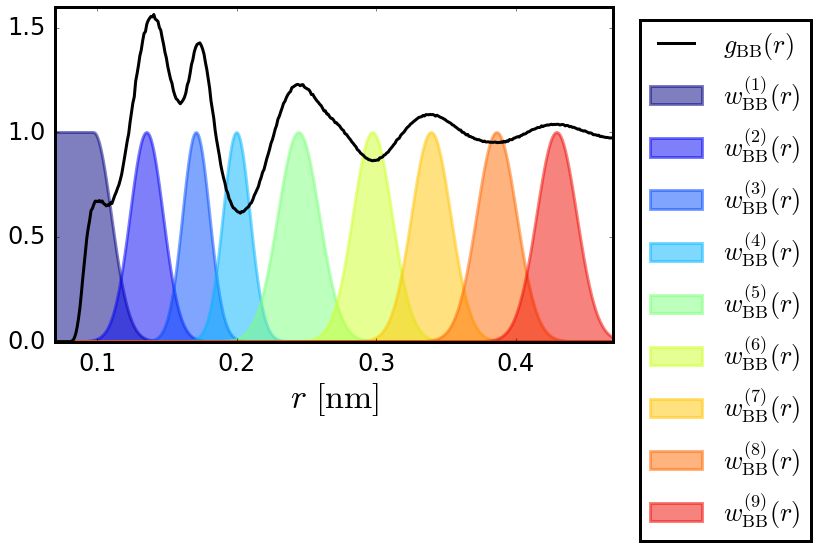

In [35]:
# replot for a figure describing the features
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
#
plt.plot(r_BB,gr_BB,color='k',linewidth=3.0,label=r'$g_{\rm{BB}}(r)$')
plt.fill_between( r_BB, weight_BB_1, alpha=0.5, color=model_colors[0], linewidth=3.0, label=r'$w_{\rm{BB}}^{(1)}(r)$' )
plt.fill_between( r_BB, weight_BB_2, alpha=0.5, color=model_colors[1], linewidth=3.0, label=r'$w_{\rm{BB}}^{(2)}(r)$' )
plt.fill_between( r_BB, weight_BB_3, alpha=0.5, color=model_colors[2], linewidth=3.0, label=r'$w_{\rm{BB}}^{(3)}(r)$' )
plt.fill_between( r_BB, weight_BB_4, alpha=0.5, color=model_colors[3], linewidth=3.0, label=r'$w_{\rm{BB}}^{(4)}(r)$' )
plt.fill_between( r_BB, weight_BB_5, alpha=0.5, color=model_colors[4], linewidth=3.0, label=r'$w_{\rm{BB}}^{(5)}(r)$' )
plt.fill_between( r_BB, weight_BB_6, alpha=0.5, color=model_colors[5], linewidth=3.0, label=r'$w_{\rm{BB}}^{(6)}(r)$' )
plt.fill_between( r_BB, weight_BB_7, alpha=0.5, color=model_colors[6], linewidth=3.0, label=r'$w_{\rm{BB}}^{(7)}(r)$' )
plt.fill_between( r_BB, weight_BB_8, alpha=0.5, color=model_colors[7], linewidth=3.0, label=r'$w_{\rm{BB}}^{(8)}(r)$' )
plt.fill_between( r_BB, weight_BB_9, alpha=0.5, color=model_colors[8], linewidth=3.0, label=r'$w_{\rm{BB}}^{(9)}(r)$' )
#

ax.spines['left'].set_linewidth(3.0)
ax.spines['right'].set_linewidth(3.0)
ax.spines['top'].set_linewidth(3.0)
ax.spines['bottom'].set_linewidth(3.0)
plt.xlabel(r'$r \,\, [\rm{nm}]$',fontsize='34',fontweight='bold')
#plt.ylabel('abs err',fontsize='28',labelpad=10)
plt.yticks([0,0.5,1.0,1.5],fontsize='24')
#eqm_prop_label = [r'$\langle N_c \rangle $',r'$\langle N_h \rangle$',r'$\langle N_s \rangle$',r'$\langle N_l \rangle$']
plt.xticks([0.1,0.2,0.3,0.4,0.5],fontsize='24')
ax.tick_params(axis='both', which='major', pad=10)
# legend
plt.legend()
legend = plt.legend(fontsize='26',loc='upper center', bbox_to_anchor=(1.2, 1.))
frame = legend.get_frame()
frame.set_linewidth('3.0')
ltext = legend.get_texts()
plt.setp(ltext, fontweight='normal')
#
plt.ylim([0,1.6])
plt.xlim([0.07,0.47])
plt.savefig('fig_gBB_feat-weights.svg', format='svg', dpi=1200)
plt.savefig('fig_gBB_feat-weights.eps', format='eps', dpi=1200)
plt.show()

In [36]:
# save all the data for this rdf
np.savez('data_BB_rdf', sel=sel_2, pairs_excl=BB_pairs_excl, r=r_BB, gr=gr_BB, N_solshel=9, solshel_max=[solshel_max_BB_1,solshel_max_BB_2,solshel_max_BB_3,solshel_max_BB_4,solshel_max_BB_5,solshel_max_BB_6,solshel_max_BB_7,solshel_max_BB_8,solshel_max_BB_9], sig=[sig_BB_1,sig_BB_2,sig_BB_3,sig_BB_4,sig_BB_5,sig_BB_6,sig_BB_7,sig_BB_8,sig_BB_9], rcut=[rcut_BB_1,rcut_BB_2,rcut_BB_3,rcut_BB_4,rcut_BB_5,rcut_BB_6,rcut_BB_7,rcut_BB_8,rcut_BB_9], weight=[weight_BB_1,weight_BB_2,weight_BB_3,weight_BB_4,weight_BB_5,weight_BB_6,weight_BB_7,weight_BB_8,weight_BB_9])




